In [1]:
import sqlite3

import numpy as np
import pandas as pd
import math
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# 1. Data Exploration and Preprocessing:

- _Connect to the SQLite database and perform initial data exploration._
- _Handle any data quality issues._

The sqlite3 library was used to connect to the database file, read the tables and load the data into the dataframes.

The **info** method was used to understand the data structure of each dataframe and the **describe** method to get basic statistical information.

The data columns were converted from object to datetime.

There are null values that may need to be addressed in later steps.

In [2]:
db_file_name = 'case database.db'

try:
    conn = sqlite3.connect(db_file_name)
except Exception as e:
    print(e)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

Table Name : [('users',), ('emotional_data',), ('loans',)]


In [3]:
df_users = pd.read_sql_query('SELECT * FROM users', conn)
df_emotional_data = pd.read_sql_query('SELECT * FROM emotional_data', conn)
df_loans = pd.read_sql_query('SELECT * FROM loans', conn)
conn.close()

In [4]:
df_users.shape, df_emotional_data.shape, df_loans.shape

((734, 7), (2440948, 12), (1188, 10))

In [5]:
df_users.head()

,user_id,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
0,1,5.69,2020-05-21,None,32700.0,0.05,12.0
1,2,NaN,None,None,NaN,NaN,NaN
2,3,5.61,2023-12-04,2025-04-26,9500.0,0.09,6.0
3,4,5.64,2020-05-14,None,1800.0,0.11,3.0
4,5,5.64,2021-04-29,None,1700.0,0.11,3.0


In [6]:
df_emotional_data.head()

,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,preceding_event,grade
0,1,2019-04-07 22:50:39,4.0,night,anticipation,None,cooking,None,cloudy,energetic,criticism,3.72
1,1,2019-04-07 14:02:53,9.0,afternoon,boredom,parent,volunteering,home,snowy,None,good news,4.79
2,1,2019-04-07 03:16:21,7.0,night,shame,neighbor,in meeting,work,sunny,tired,None,2.94
3,1,2019-04-08 17:10:35,5.0,evening,joy,stranger,argument,None,windy,rested,compliment,5.35
4,1,2019-04-08 16:12:02,1.0,afternoon,joy,child,clothes shopping,None,sunny,None,surprise,2.97


In [7]:
df_loans.head()

,loan_id,user_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid,status
0,1,1,29955,47928.00,2021-06-14,2022-06-09,2021-10-05,3994.00,35596.53,paid
1,2,1,15473,24756.80,2022-12-06,2023-12-01,2023-08-17,2063.07,22023.24,paid
2,3,1,15781,25249.60,2025-04-24,2026-04-19,2025-04-28,2104.13,15886.21,paid
3,4,3,8715,13421.10,2024-10-28,2025-04-26,None,2236.85,0.00,late
4,5,4,1721,2288.93,2021-03-09,2021-06-07,2021-03-29,762.98,1847.21,paid


In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        734 non-null    int64  
 1   score          667 non-null    float64
 2   approved_date  667 non-null    object 
 3   denied_date    178 non-null    object 
 4   credit_limit   667 non-null    float64
 5   interest_rate  667 non-null    float64
 6   loan_term      667 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 40.3+ KB


In [9]:
df_users['approved_date'] = pd.to_datetime(df_users['approved_date'])
df_users['denied_date'] = pd.to_datetime(df_users['denied_date'])

In [10]:
df_users.describe()

,user_id,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
count,734.000000,667.000000,667,178,667.000000,667.000000,667.000000
mean,367.500000,5.668486,2021-11-03 20:04:40.659670272,2023-07-18 22:06:44.494382080,13645.727136,0.086237,10.668666
min,1.000000,5.600000,2020-01-27 00:00:00,2021-01-13 00:00:00,1000.000000,0.020000,3.000000
25%,184.250000,5.620000,2020-09-25 00:00:00,2022-09-30 00:00:00,2200.000000,0.050000,3.000000
50%,367.500000,5.650000,2021-07-22 00:00:00,2023-08-28 12:00:00,5900.000000,0.090000,6.000000
75%,550.750000,5.700000,2022-09-19 00:00:00,2024-05-12 00:00:00,23550.000000,0.110000,12.000000
max,734.000000,6.110000,2025-04-22 00:00:00,2025-05-01 00:00:00,49800.000000,0.130000,24.000000
std,212.031837,0.062003,NaN,NaN,14883.705105,0.035197,7.702791


In [11]:
df_users.isnull().sum()

user_id            0
score             67
approved_date     67
denied_date      556
credit_limit      67
interest_rate     67
loan_term         67
dtype: int64

In [12]:
df_emotional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440948 entries, 0 to 2440947
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          int64  
 1   timestamp        object 
 2   intensity        float64
 3   time_of_day      object 
 4   primary_emotion  object 
 5   relationship     object 
 6   situation        object 
 7   location         object 
 8   weather          object 
 9   physical_state   object 
 10  preceding_event  object 
 11  grade            float64
dtypes: float64(2), int64(1), object(9)
memory usage: 223.5+ MB


In [13]:
df_emotional_data['timestamp'] = pd.to_datetime(df_emotional_data['timestamp'])

In [14]:
df_emotional_data.describe()

,user_id,timestamp,intensity,grade
count,2.440948e+06,2440948,2.440948e+06,2.440948e+06
mean,3.674158e+02,2022-04-19 16:17:14.561224192,5.499650e+00,4.595637e+00
min,1.000000e+00,2019-04-07 00:00:12,1.000000e+00,8.300000e-01
25%,1.840000e+02,2020-10-12 17:06:52.249999872,3.000000e+00,3.040000e+00
50%,3.670000e+02,2022-04-19 22:21:54,5.000000e+00,4.190000e+00
75%,5.510000e+02,2023-10-25 14:33:48.750000128,8.000000e+00,6.020000e+00
max,7.340000e+02,2025-05-01 23:59:52,1.000000e+01,1.000000e+01
std,2.118997e+02,NaN,2.871508e+00,1.855771e+00


In [15]:
df_emotional_data.isnull().sum()

user_id                 0
timestamp               0
intensity               0
time_of_day             0
primary_emotion         0
relationship       561367
situation          560784
location           560021
weather            559959
physical_state     562260
preceding_event    561935
grade                   0
dtype: int64

In [16]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             1188 non-null   int64  
 1   user_id             1188 non-null   int64  
 2   loan_amount         1188 non-null   int64  
 3   total_amount        1188 non-null   float64
 4   issue_date          1188 non-null   object 
 5   due_date            1188 non-null   object 
 6   paid_date           947 non-null    object 
 7   installment_amount  1188 non-null   float64
 8   loan_amount_paid    1188 non-null   float64
 9   status              1188 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 92.9+ KB


In [17]:
df_loans['issue_date'] = pd.to_datetime(df_loans['issue_date'])
df_loans['due_date'] = pd.to_datetime(df_loans['due_date'])
df_loans['paid_date'] = pd.to_datetime(df_loans['paid_date'])

In [18]:
df_loans.describe()

,loan_id,user_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid
count,1188.000000,1188.000000,1188.000000,1188.000000,1188,1188,947,1188.000000,1188.000000
mean,594.500000,356.154040,6172.994108,11145.110522,2023-04-09 08:33:56.363636480,2024-01-10 19:06:40,2023-07-24 04:50:25.976768768,978.153687,7529.056843
min,1.000000,1.000000,1000.000000,1256.120000,2020-07-17 00:00:00,2020-11-13 00:00:00,2020-08-18 00:00:00,66.110000,0.000000
25%,297.750000,170.750000,1280.000000,1928.832500,2022-04-08 18:00:00,2022-12-19 00:00:00,2022-07-27 00:00:00,439.120000,1437.850000
50%,594.500000,348.000000,1945.000000,3058.215000,2023-05-17 00:00:00,2024-02-03 00:00:00,2023-08-25 00:00:00,614.610000,2247.150000
75%,891.250000,534.000000,6873.750000,11150.730000,2024-04-21 00:00:00,2025-01-11 00:00:00,2024-08-27 00:00:00,1058.240000,7841.485000
max,1188.000000,734.000000,46785.000000,99824.640000,2025-04-28 00:00:00,2027-04-18 00:00:00,2025-05-01 00:00:00,7173.700000,81090.880000
std,343.090367,213.036507,8743.494609,16783.924757,NaN,NaN,NaN,958.665229,11635.863601


In [19]:
df_loans.isnull().sum()

loan_id                 0
user_id                 0
loan_amount             0
total_amount            0
issue_date              0
due_date                0
paid_date             241
installment_amount      0
loan_amount_paid        0
status                  0
dtype: int64

# 2. Emotional Pattern Analysis:

- _Identify dominant emotional patterns for users over time._
- _Analyze how emotions correlate with different contexts (e.g., relationships, situations, time of day)._

The most frequent records are of good feelings (joy, love, pride), at the beginning and end of the day (morning and night) and intensity values are distributed in a similar way.

Grades are higher for good feelings as expected but the averages are relatively low.

By classifying the intensity of the emotion as high, medium and low, the influence of higher intensities for good emotions on the grades becomes more evident.

PS: I'm assuming that the emotion 'pride' is related to satisfaction, not arrogance.

In [20]:
df_emotional_data.groupby(['primary_emotion']).size().sort_values(ascending=False)

primary_emotion
joy             271338
love            246687
pride           246085
anticipation    222758
amusement       197492
trust           197352
relief          197309
surprise        172786
sadness          98561
boredom          97957
contempt         74139
shame            74091
guilt            73618
confusion        73569
frustration      49567
disgust          49509
jealousy         48914
fear             24660
anxiety          24556
dtype: int64

In [21]:
df_emotional_data.groupby(['time_of_day']).size().sort_values(ascending=False)

time_of_day
night        813762
morning      712239
afternoon    508237
evening      406710
dtype: int64

In [22]:
df_emotional_data.groupby(['intensity']).size().sort_values(ascending=False)

intensity
4.0     244764
5.0     244724
2.0     244483
9.0     244102
10.0    244030
8.0     244007
3.0     243979
6.0     243915
7.0     243512
1.0     243432
dtype: int64

In [23]:
df_emotional_data.groupby(['primary_emotion'])[['grade']].mean().sort_values(by=['grade'], ascending=False)

,grade
primary_emotion,
joy,5.906440
love,5.556752
pride,5.548512
anticipation,5.192971
trust,4.840178
relief,4.837421
amusement,4.830629
surprise,4.481064
sadness,3.410415


In [24]:
df_emotional_data['grade'].corr(df_emotional_data['intensity'])

np.float64(0.7359224555525831)

In [25]:
df_emotional_data['intensity_level'] = np.where(df_emotional_data['intensity'] < 5, 'low',
                                                np.where(df_emotional_data['intensity'] >= 8, 'high',
                                                         'medium')
                                               )
df_emotional_data['intensity_level'].value_counts()

intensity_level
low       976658
medium    732151
high      732139
Name: count, dtype: int64

In [26]:
df_emotional_data.groupby(['primary_emotion', 'intensity_level'])[['grade']].mean().unstack(level='intensity_level').sort_values(by=[('grade', 'high')], ascending=False)

grade                    
intensity_level      high       low    medium
primary_emotion                              
joy              8.404980  3.766977  6.263232
pride            7.825553  3.603207  5.870689
love             7.824856  3.608492  5.871680
anticipation     7.241044  3.439782  5.484876
amusement        6.656442  3.277169  5.092002
trust            6.651253  3.279486  5.096127
relief           6.651030  3.281469  5.097284
surprise         6.068467  3.123719  4.705888
sadness          4.319078  2.630978  3.537155
boredom          4.316491  2.627912  3.536856
shame            3.740270  2.462576  3.146697
guilt            3.733375  2.463365  3.147247
contempt         3.733009  2.464214  3.147346
confusion        3.730827  2.469049  3.149395
frustration      3.150472  2.301274  2.764455
jealousy         3.149540  2.300683  2.756503
disgust          3.145789  2.303379  2.756436
fear             2.568709  2.145360  2.367650
anxiety          2.559516  2.140644  2.366384

In [27]:
np.sort(df_emotional_data['primary_emotion'].unique())

array(['amusement', 'anticipation', 'anxiety', 'boredom', 'confusion',
       'contempt', 'disgust', 'fear', 'frustration', 'guilt', 'jealousy',
       'joy', 'love', 'pride', 'relief', 'sadness', 'shame', 'surprise',
       'trust'], dtype=object)

In [28]:
dict_emotion_type = {
'emotion': ['amusement', 'anticipation', 'anxiety', 'boredom', 'confusion', 'contempt', 'disgust', 'fear', 'frustration',
            'guilt', 'jealousy', 'joy', 'love', 'pride', 'relief', 'sadness', 'shame', 'surprise', 'trust'],
'emotion_type': ['good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad',
         'bad', 'bad', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good']
}

df_emotion_type = pd.DataFrame(dict_emotion_type)
df_emotion_type

,emotion,emotion_type
0,amusement,good
1,anticipation,good
2,anxiety,bad
3,boredom,bad
4,confusion,bad
5,contempt,bad
6,disgust,bad
7,fear,bad
8,frustration,bad
9,guilt,bad


In [29]:
df_emotional_data = df_emotional_data.merge(df_emotion_type, left_on='primary_emotion', right_on='emotion')
df_emotional_data.drop(columns=['emotion'], inplace=True)
df_emotional_data.head()

,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,preceding_event,grade,intensity_level,emotion_type
0,1,2019-04-07 22:50:39,4.0,night,anticipation,None,cooking,None,cloudy,energetic,criticism,3.72,low,good
1,1,2019-04-07 14:02:53,9.0,afternoon,boredom,parent,volunteering,home,snowy,None,good news,4.79,high,bad
2,1,2019-04-07 03:16:21,7.0,night,shame,neighbor,in meeting,work,sunny,tired,None,2.94,medium,bad
3,1,2019-04-08 17:10:35,5.0,evening,joy,stranger,argument,None,windy,rested,compliment,5.35,medium,good
4,1,2019-04-08 16:12:02,1.0,afternoon,joy,child,clothes shopping,None,sunny,None,surprise,2.97,low,good


## 2.1 Emotions over time

Emotions were analyzed on the timeline for different periods: monthly (year/month), month of the year (month) and day of the week.

Considering that for each period the number of records is different and the absolute frequency values may be on a different scale, the percentage of emotion frequency for each period was used, making the analysis on the timeline fairly comparable and easy to visualize.

It is possible to say that, in general, emotions maintain the same pattern in different perspectives of the timeline. The emotions chart on the timeline has been divided into three sub-charts for better reading.

In [30]:
def plot_emotion_timeline(df_count, label_period, list_order=None, n_top=0, n_subplot=0):
    df_percentage = df_count.div(df_count.sum(axis=1), axis=0) * 100

    if list_order != None:
        df_percentage = df_percentage.reindex(list_order)

    if n_top > 0:
        top_emotions = df_percentage.sum().nlargest(n_top_emotions).index
        df_percentage = df_percentage[top_emotions]

    if n_subplot == 0:
        df_percentage.plot(kind='line', figsize=(14, 7), marker='o')
        plt.title('Emotional Patterns Over Time')
        plt.xlabel(label_period)
        plt.ylabel('Emotion (%)')
        plt.legend(title='Emotions')
        plt.show()
    else:
        list_emotions = df_percentage.sum().sort_values(ascending=False).index.tolist()
        
        fig, axes = plt.subplots(n_subplot, 1, figsize=(8, 3 * n_subplot))

        end = 0
        
        for i, col in enumerate(range(0,n_subplot)):
            n_cols = math.ceil(len(list_emotions) / n_subplot)
            start = end
            end = start + n_cols
            
            df_percentage[list_emotions[start:end]].plot(ax=axes[i])
            axes[i].set_xlabel('')
            axes[i].set_ylabel('Emotion (%)')
            axes[i].legend(loc='upper right')

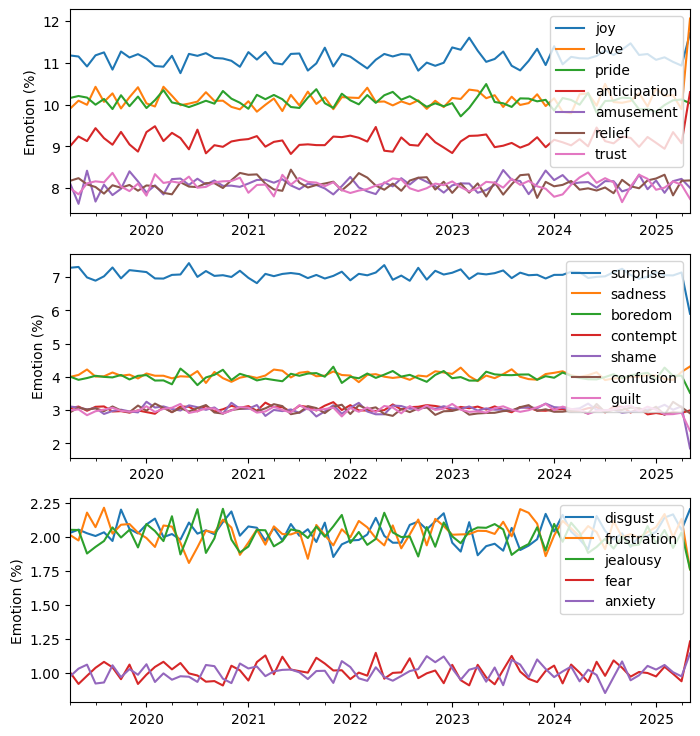

In [31]:
# Period: Monthly (Year/Month)
df_emotion_counts = df_emotional_data.groupby([df_emotional_data['timestamp'].dt.to_period('M'), 'primary_emotion']).size().unstack(fill_value=0)

plot_emotion_timeline(df_emotion_counts, 'Monthly (Year/Month)', None, 0, 3)

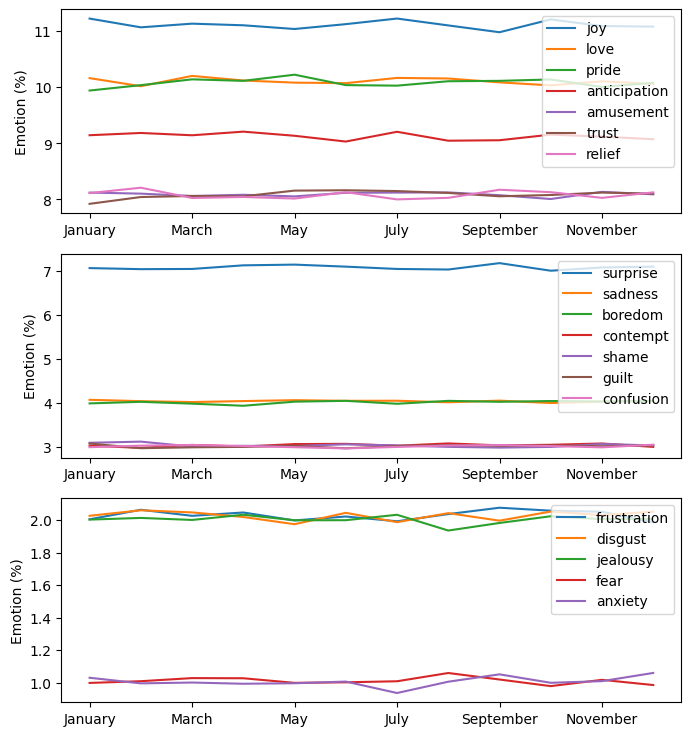

In [32]:
# Period: Month of the year
df_emotion_counts = df_emotional_data.groupby([df_emotional_data['timestamp'].dt.month_name(), 'primary_emotion']).size().unstack(fill_value=0)
list_order = list(calendar.month_name)[1:]

plot_emotion_timeline(df_emotion_counts, 'Month', list_order, 0, 3)

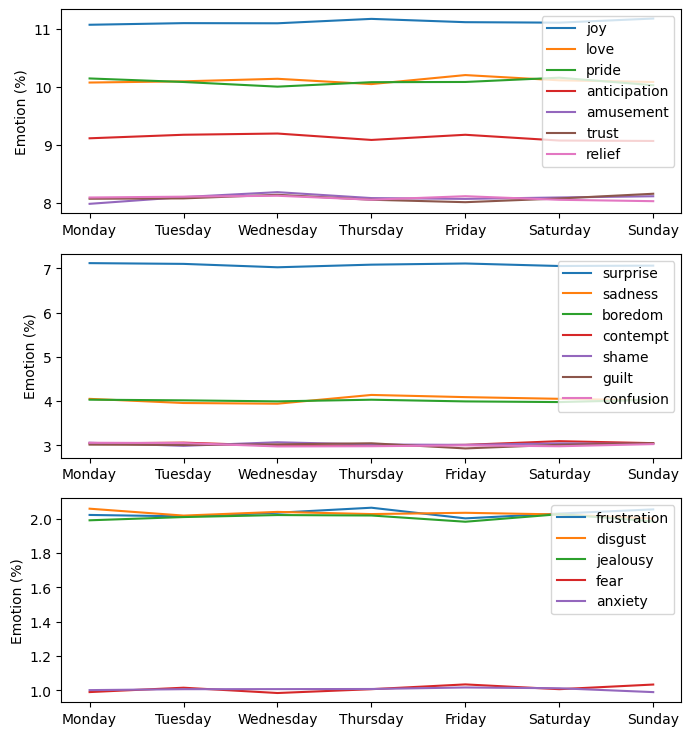

In [33]:
# Period: Weekday
df_emotion_counts = df_emotional_data.groupby([df_emotional_data['timestamp'].dt.day_name(), 'primary_emotion']).size().unstack(fill_value=0)
list_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plot_emotion_timeline(df_emotion_counts, 'Weekday', list_order, 0, 3)

## 2.2 Emotions correlation

Emotions were crossed with contextual data (categorical data) and evaluated using chi-square and v-cramer tests, but did not show a significant level of association.

In [34]:
def get_categorical_correlation(df, x, y):
    cross_tab = pd.crosstab(df[x], df[y])
    chi2, p, dof, ex = chi2_contingency(cross_tab)
    n = cross_tab.sum().sum()
    v_cramer = np.sqrt(chi2 / (n * (min(cross_tab.shape) - 1)))

    return chi2, p, v_cramer

In [35]:
list_context = ['time_of_day', 'relationship', 'situation', 'location', 'weather', 'physical_state', 'preceding_event']

In [36]:
for context in list_context:
    chi2, p_value, v_cramer = get_categorical_correlation(df_emotional_data, 'primary_emotion', context)
    print(f'{context}, p-value: {p_value}, v-cramer: {v_cramer}')

time_of_day, p-value: 0.5171927488024886, v-cramer: 0.002687522806542472
relationship, p-value: 0.9119903638822561, v-cramer: 0.0031765138940893283
situation, p-value: 0.794998057338167, v-cramer: 0.0038923272489752225
location, p-value: 0.7957191854785416, v-cramer: 0.0028688086581500445
weather, p-value: 0.48053925164395844, v-cramer: 0.003094773665250458
physical_state, p-value: 0.004935422278027692, v-cramer: 0.00369681761599061
preceding_event, p-value: 0.45084845627671605, v-cramer: 0.003110455115086552


# 3. Loan-Emotion Correlation:

- _Analyze the relationship between emotional patterns and loan terms (amount, interest rate)._
- _Identify which emotional factors have the strongest influence on loan results._

Regarding loans, it is noted that there are 4 fixed terms (3, 6, 12 and 24). Most loans are short-term (3, 6), with a value of less than 2000 and rates around 11%. For longer terms, the average loan value is over 10000 and rates around 5%.

To relate emotions to loans, a dataframe was generated combining the emotion data from the day the loan was issued. Since each emotion tends to have its frequency repeated independently in the timeline, it would not be very useful to use the entire history.

No significant correlations were found between emotions and loan data.

Looking at the statistical data, some emotions stand out:

- Anxiety, high concentration of short-term loans

- Shame, high number of long-term loans

In [37]:
df_loan_terms = df_loans.merge(df_users, left_on='user_id', right_on='user_id')
df_loan_terms.head()

,loan_id,user_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid,status,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
0,1,1,29955,47928.00,2021-06-14,2022-06-09,2021-10-05,3994.00,35596.53,paid,5.69,2020-05-21,NaT,32700.0,0.05,12.0
1,2,1,15473,24756.80,2022-12-06,2023-12-01,2023-08-17,2063.07,22023.24,paid,5.69,2020-05-21,NaT,32700.0,0.05,12.0
2,3,1,15781,25249.60,2025-04-24,2026-04-19,2025-04-28,2104.13,15886.21,paid,5.69,2020-05-21,NaT,32700.0,0.05,12.0
3,4,3,8715,13421.10,2024-10-28,2025-04-26,NaT,2236.85,0.00,late,5.61,2023-12-04,2025-04-26,9500.0,0.09,6.0
4,5,4,1721,2288.93,2021-03-09,2021-06-07,2021-03-29,762.98,1847.21,paid,5.64,2020-05-14,NaT,1800.0,0.11,3.0


In [38]:
df_loan_terms.groupby(['loan_term']).agg({'loan_term': 'count', 'loan_amount': ['mean'], 'interest_rate': ['mean']})

,loan_term,loan_amount,interest_rate
,count,mean,mean
loan_term,,,
3.0,377,1800.063660,0.114828
6.0,356,1760.292135,0.115562
12.0,270,11794.144444,0.061000
24.0,185,15371.945946,0.049405


In [39]:
np.sort(df_loan_terms['interest_rate'].unique())

array([0.02, 0.05, 0.07, 0.09, 0.11, 0.13])

Text(0.5, 1.0, 'Interest Rate Histogram')

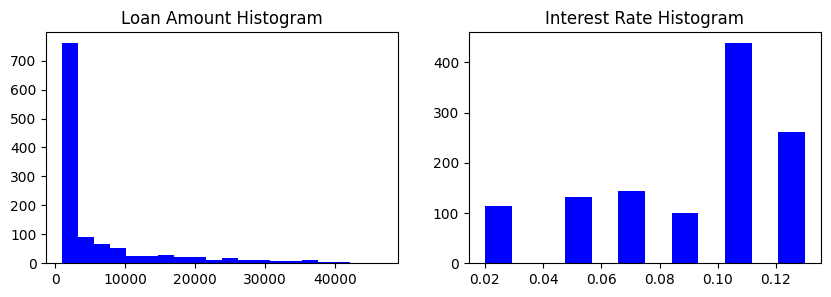

In [40]:
plt.figure(figsize=[10, 3])

plt.subplot(1, 2, 1); plt.hist(df_loan_terms['loan_amount'], bins=20, color='blue'); plt.title('Loan Amount Histogram')
plt.subplot(1, 2, 2); plt.hist(df_loan_terms['interest_rate'], bins=12, color='blue'); plt.title('Interest Rate Histogram')

In [41]:
df_emotional_data['emotional_date'] = pd.to_datetime(df_emotional_data['timestamp'].dt.date)
df_loan_emotional = df_loan_terms.merge(df_emotional_data, left_on=['user_id', 'issue_date'], right_on=['user_id', 'emotional_date']).sort_values(by=['user_id', 'timestamp'])
#df_loan_emotional = df_loan_emotional.loc[df_loan_emotional.groupby('loan_id')['intensity'].idxmax()]
len(df_loan_terms['loan_id'].unique()), len(df_loan_emotional), len(df_loan_emotional['loan_id'].unique())

(1188, 1822, 908)

In [42]:
pd.get_dummies(df_loan_emotional[['primary_emotion', 'loan_term', 'interest_rate', 'loan_amount']], columns=['primary_emotion'], drop_first=True).corr()

,loan_term,interest_rate,loan_amount,primary_emotion_anticipation,primary_emotion_anxiety,primary_emotion_boredom,primary_emotion_confusion,primary_emotion_contempt,primary_emotion_disgust,primary_emotion_fear,...,primary_emotion_guilt,primary_emotion_jealousy,primary_emotion_joy,primary_emotion_love,primary_emotion_pride,primary_emotion_relief,primary_emotion_sadness,primary_emotion_shame,primary_emotion_surprise,primary_emotion_trust
loan_term,1.000000,-0.749777,0.622210,0.017948,-0.038522,0.000506,-0.009182,0.028576,0.039644,0.007245,...,0.002438,-0.023567,0.017406,-0.022090,-0.037763,-0.037156,0.001046,0.027880,-0.033211,0.018098
interest_rate,-0.749777,1.000000,-0.661949,-0.021518,0.031313,0.029912,-0.024166,-0.020655,-0.018895,0.006986,...,0.016905,0.036167,-0.020992,0.020312,0.013633,0.016451,-0.005140,-0.013753,0.006583,-0.006603
loan_amount,0.622210,-0.661949,1.000000,0.030827,-0.010832,0.014942,0.043566,0.008853,-0.011223,0.004574,...,0.007755,-0.036036,0.025888,-0.019884,-0.020784,-0.038469,-0.011830,0.008037,-0.023479,0.016055
primary_emotion_anticipation,0.017948,-0.021518,0.030827,1.000000,-0.035465,-0.064121,-0.058684,-0.059196,-0.049873,-0.038597,...,-0.058168,-0.037062,-0.107840,-0.107840,-0.111056,-0.095734,-0.069639,-0.046185,-0.087063,-0.089653
primary_emotion_anxiety,-0.038522,0.031313,-0.010832,-0.035465,1.000000,-0.022098,-0.020224,-0.020401,-0.017188,-0.013302,...,-0.020047,-0.012773,-0.037165,-0.037165,-0.038274,-0.032993,-0.024000,-0.015917,-0.030005,-0.030897
primary_emotion_boredom,0.000506,0.029912,0.014942,-0.064121,-0.022098,1.000000,-0.036566,-0.036885,-0.031076,-0.024050,...,-0.036245,-0.023094,-0.067196,-0.067196,-0.069200,-0.059652,-0.043392,-0.028778,-0.054250,-0.055863
primary_emotion_confusion,-0.009182,-0.024166,0.043566,-0.058684,-0.020224,-0.036566,1.000000,-0.033758,-0.028441,-0.022011,...,-0.033171,-0.021135,-0.061498,-0.061498,-0.063332,-0.054594,-0.039713,-0.026338,-0.049649,-0.051126
primary_emotion_contempt,0.028576,-0.020655,0.008853,-0.059196,-0.020401,-0.036885,-0.033758,1.000000,-0.028689,-0.022203,...,-0.033461,-0.021320,-0.062035,-0.062035,-0.063885,-0.055070,-0.040059,-0.026568,-0.050083,-0.051572
primary_emotion_disgust,0.039644,-0.018895,-0.011223,-0.049873,-0.017188,-0.031076,-0.028441,-0.028689,1.000000,-0.018706,...,-0.028191,-0.017962,-0.052265,-0.052265,-0.053823,-0.046397,-0.033750,-0.022384,-0.042195,-0.043450
primary_emotion_fear,0.007245,0.006986,0.004574,-0.038597,-0.013302,-0.024050,-0.022011,-0.022203,-0.018706,1.000000,...,-0.021817,-0.013901,-0.040448,-0.040448,-0.041654,-0.035907,-0.026120,-0.017323,-0.032655,-0.033626


In [43]:
df_loan_emotional.groupby('primary_emotion').agg({
    'loan_amount': ['mean', 'median', 'std'],
    'interest_rate': ['mean', 'median', 'std'],
    'loan_term': ['mean', 'median', 'std']
})

loan_amount                       interest_rate         \
                        mean  median           std          mean median   
primary_emotion                                                           
amusement        6455.129870  2049.0   8050.080202      0.090974   0.11   
anticipation     6922.941176  1912.5   9892.017156      0.090706   0.11   
anxiety          5250.136364  1311.5   8627.060352      0.102727   0.11   
boredom          6738.971429  1820.5  10930.492277      0.098143   0.11   
confusion        8147.271186  2044.0  11218.911286      0.088475   0.11   
contempt         6508.166667  2223.0   8549.878366      0.089167   0.11   
disgust          5472.465116  1810.0   6341.935349      0.088837   0.11   
fear             6422.346154  2406.0   8048.707503      0.095000   0.11   
frustration      5641.369565  1845.5   7636.627052      0.092391   0.11   
guilt            6463.258621  1834.0   9671.777029      0.096207   0.11   
jealousy         3406.250000  1587.0   5095.945082      0.103750   0.11   
joy              6758.394595  1967.0   9162.468534      0.090865   0.11   
love             5584.854054  1881.0   8266.579537      0.095081   0.11   
pride            5577.205128  1811.0   8183.162554      0.094359   0.11   
relief           4983.604027  1840.0   6650.370049      0.094899   0.11   
sadness          5624.939024  1764.0   8431.179651      0.092195   0.11   
shame            6575.783784  2257.0   9194.823810      0.089730   0.11   
surprise         5349.008000  1931.0   7433.161277      0.093840   0.11   
trust            6589.787879  1924.5   9273.695581      0.092197   0.11   

                           loan_term                   
                      std       mean median       std  
primary_emotion                                        
amusement        0.035842  10.577922    6.0  7.882953  
anticipation     0.034991   9.776471    6.0  7.357927  
anxiety          0.030423   6.818182    3.0  6.359368  
boredom          0.032806   9.385714    6.0  7.239771  
confusion        0.032527   9.000000    6.0  7.046643  
contempt         0.035668  10.500000    6.0  7.801564  
disgust          0.036003  11.232558    6.0  8.462346  
fear             0.030100   9.807692    6.0  7.709834  
frustration      0.034972   9.260870    6.0  7.478665  
guilt            0.030194   9.465517    6.0  8.139605  
jealousy         0.027317   7.875000    6.0  5.922048  
joy              0.036554   9.745946    6.0  7.337019  
love             0.032439   8.886486    6.0  7.017299  
pride            0.034252   8.569231    6.0  6.701214  
relief           0.034320   8.456376    6.0  7.096329  
sadness          0.037119   9.402439    6.0  7.996696  
shame            0.038621  10.783784   12.0  7.888582  
surprise         0.034379   8.472000    6.0  6.353277  
trust            0.032977   9.840909    6.0  7.590502

In [44]:
list_emotion = ['anxiety', 'shame']

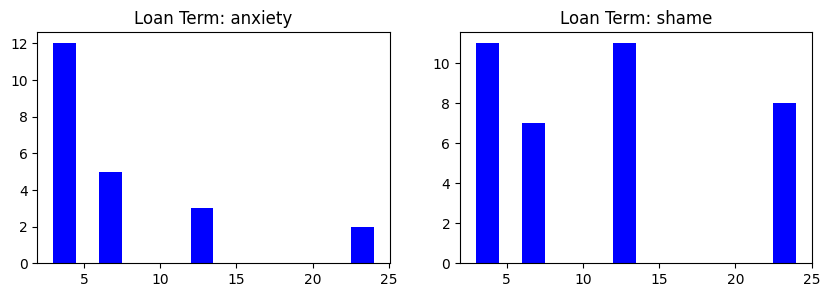

In [45]:
n_rows = 1
n_cols = 2

plt.figure(figsize=[10, 3])
for i in range(0, len(list_emotion)):
    plt.subplot(n_rows, n_cols, i+1);plt.hist(df_loan_emotional[df_loan_emotional['primary_emotion'] == list_emotion[i]]['loan_term'], bins=14, color='blue'); plt.title('Loan Term: ' + list_emotion[i]);

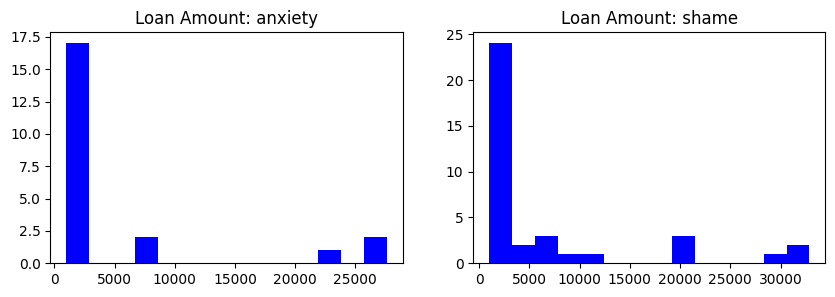

In [46]:
n_rows = 1
n_cols = 2

plt.figure(figsize=[10, 3])
for i in range(0, len(list_emotion)):
    plt.subplot(n_rows, n_cols, i+1);plt.hist(df_loan_emotional[df_loan_emotional['primary_emotion'] == list_emotion[i]]['loan_amount'], bins=14, color='blue'); plt.title('Loan Amount: ' + list_emotion[i]);

# 4. Lending Operation Assessment

- _Evaluate the effectiveness of the lending policy (interest rates and loan amount) in terms of the default_
- _Measure growth and profitability of the lending operation._
- _Analyze disbushment, loan performance, and revenue trends over time._

There is a higher frequency of default in shorter terms, approximately 20% and 15% for 3 and 6 months respectively.

The average loan amount increased from 56919 at the beginning of the operation to 126439.95, an increase of 122.14%.

The total amount loaned was 7333517 and the total amount received was 8944519.53, generating a gross profit of 21.97%.

Revenue has a growth tendency while disbursement has remained stable.

In [47]:
#df_loan_eval = df_loan_terms.groupby(['loan_term', 'status']).agg({'loan_term': 'count'}).rename(columns={'loan_term': 'count'})
#df_loan_eval['count_perc'] = df_loan_eval.div(df_loan_eval.groupby(['loan_term']).agg({'count': 'sum'}), axis=1).round(4) * 100

df_loan_eval = df_loan_terms.groupby(['loan_term', 'status']).agg({'loan_term': 'count', 'loan_amount': ['mean'], 'interest_rate': ['mean']})
df_loan_eval.columns = ['_'.join(col) for col in df_loan_eval.columns]
df_loan_eval['total_perc'] = df_loan_eval[['loan_term_count']].div(df_loan_eval['loan_term_count'].sum(), axis=1).round(4) * 100
df_loan_eval['loan_term_perc'] = df_loan_eval[['loan_term_count']].div(df_loan_eval.groupby(['loan_term']).agg({'loan_term_count': 'sum'}), axis=1).round(4) * 100

df_loan_eval.rename(columns={'loan_term_count': 'count'}, inplace=True)
df_loan_eval.insert(1, 'total_perc', df_loan_eval.pop('total_perc'))
df_loan_eval.insert(2, 'loan_term_perc', df_loan_eval.pop('loan_term_perc'))
df_loan_eval

count  total_perc  loan_term_perc  loan_amount_mean  \
loan_term status                                                         
3.0       late        75        6.31           19.89       1808.746667   
          ongoing      9        0.76            2.39       2305.222222   
          paid       293       24.66           77.72       1782.324232   
6.0       late        51        4.29           14.33       2160.450980   
          ongoing      9        0.76            2.53       2280.444444   
          paid       296       24.92           83.15       1675.530405   
12.0      late        35        2.95           12.96      11395.685714   
          ongoing     14        1.18            5.19      11417.857143   
          paid       221       18.60           81.85      11881.085973   
24.0      late        17        1.43            9.19      13995.941176   
          ongoing     31        2.61           16.76      13530.096774   
          paid       137       11.53           74.05      15959.459854   

                   interest_rate_mean  
loan_term status                       
3.0       late               0.115067  
          ongoing            0.110000  
          paid               0.114915  
6.0       late               0.113529  
          ongoing            0.116667  
          paid               0.115878  
12.0      late               0.058000  
          ongoing            0.067143  
          paid               0.061086  
24.0      late               0.052941  
          ongoing            0.046452  
          paid               0.049635

In [48]:
df_temp1 = df_loan_terms.groupby(['loan_term'])[['loan_term']].count().rename(columns={'loan_term': 'total_count'})
df_temp2 = df_loan_terms[df_loan_terms['status'] == 'late'].groupby(['loan_term'])[['loan_term']].count().rename(columns={'loan_term': 'default_count'})
df_loan_default = pd.concat([df_temp1, df_temp2], axis=1)
df_loan_default['percentage'] = (df_loan_default['default_count'] / df_loan_default['total_count'] * 100).round(2)
df_loan_default

,total_count,default_count,percentage
loan_term,,,
3.0,377,75,19.89
6.0,356,51,14.33
12.0,270,35,12.96
24.0,185,17,9.19


In [49]:
df_loan_growth = pd.DataFrame(df_loan_terms.groupby(df_loan_terms['issue_date'].dt.to_period('M'))['loan_amount'].sum())
df_loan_growth['loan_amount_cum'] = df_loan_growth['loan_amount'].cumsum()
df_loan_growth['loan_amount_avg'] = df_loan_growth['loan_amount_cum'] / range(1, len(df_loan_growth) + 1)

first_value = df_loan_growth['loan_amount_avg'].iloc[0]
last_value = df_loan_growth['loan_amount_avg'].iloc[-1]

loan_amount_paid = df_loan_terms['loan_amount_paid'].sum()
loan_amount = df_loan_terms['loan_amount'].sum()

print(f'The average loan amount increased from {np.round(first_value,2)} at the beginning of the operation to {np.round(last_value,2)}, an increase of {np.round((last_value / first_value - 1) * 100, 2)}%')
print(f'The total amount loaned was {np.round(loan_amount,2)} and the total amount received was {np.round(loan_amount_paid,2)}, generating a gross profit of {np.round((loan_amount_paid / loan_amount - 1) * 100, 2)}%')

The average loan amount increased from 56919.0 at the beginning of the operation to 126439.95, an increase of 122.14%
The total amount loaned was 7333517 and the total amount received was 8944519.53, generating a gross profit of 21.97%


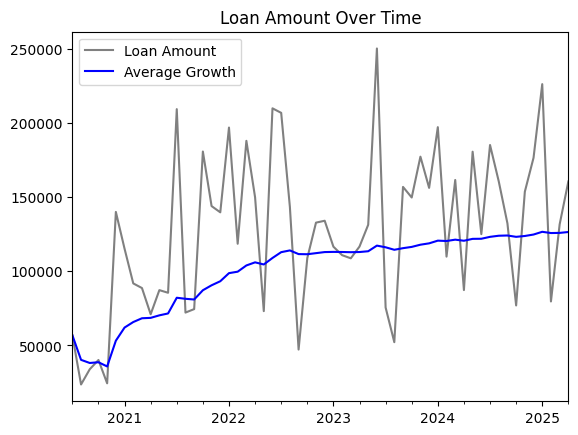

In [50]:
df_loan_growth['loan_amount'].plot(kind='line', color='gray')
plt.plot(df_loan_growth['loan_amount_avg'], color='blue')
plt.title('Loan Amount Over Time')
plt.xlabel('')
plt.legend(labels=['Loan Amount', 'Average Growth'])
plt.show()

In [51]:
start_period = df_loan_terms['issue_date'].min()
end_period = df_loan_terms['due_date'].max()

periods = pd.period_range(start=start_period, end=end_period, freq='M')

df_monthly_revenue = df_loan_terms[['loan_id']]
df_monthly_revenue.set_index('loan_id', inplace=True)

df_monthly_revenue = pd.concat([df_monthly_revenue, pd.DataFrame(columns=periods)], axis=1)

for index, row in df_loan_terms.iterrows():
    loan_id = row['loan_id']
    loan_amount_paid = row['loan_amount_paid']
    installment_amount = row['installment_amount']
    issue_date = row['issue_date'].to_period('M')
    paid_date = np.nan
    
    if pd.isna(row['paid_date']) == False:
        paid_date = row['paid_date'].to_period('M')
    
    available_amount = loan_amount_paid
    period = issue_date

    new_row = dict.fromkeys(df_monthly_revenue.columns)
    
    while available_amount > 0:
        if pd.isna(paid_date) and issue_date == paid_date:
            new_row[paid_date] = available_amount
            available_amount = 0
            
        if available_amount > installment_amount:
            if period == paid_date:
                new_row[period] = available_amount
                available_amount = 0
            else:
                new_row[period] = installment_amount
                available_amount = available_amount - installment_amount
        else:
            new_row[period] = available_amount
            available_amount = 0

        period += 1

    df_monthly_revenue.loc[loan_id] = new_row

df_loan_terms['loan_amount_paid'].sum(), df_monthly_revenue.sum().sum()

(np.float64(8944519.53), 8944519.530000001)

In [52]:
df_revenue = df_monthly_revenue.sum().to_frame()
df_revenue.columns = ['revenue']
df_revenue = df_revenue[df_revenue['revenue'] > 0]
df_revenue.head()

,revenue
2020-07,5173.91
2020-08,8830.0
2020-09,11845.58
2020-10,18289.92
2020-11,20838.13


In [53]:
df_temp = df_loan_terms[['issue_date', 'loan_amount']]
df_temp['issue_month'] = df_temp['issue_date'].dt.to_period('M')
df_disbursement = df_temp.groupby('issue_month')['loan_amount'].sum().to_frame()
df_disbursement.head()

,loan_amount
issue_month,
2020-07,56919
2020-08,23729
2020-09,33988
2020-10,40219
2020-11,24505


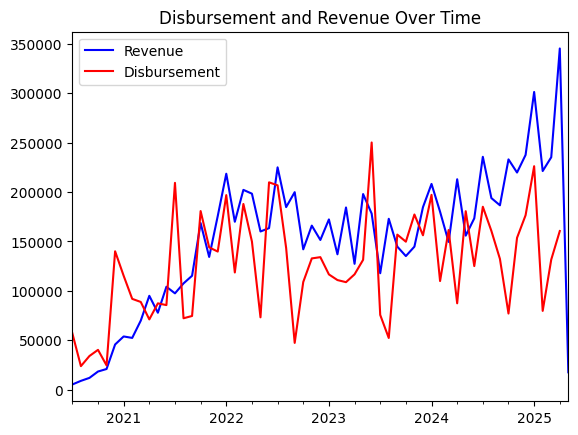

In [54]:
df_revenue['revenue'].plot(kind='line', color='blue')
plt.plot(df_disbursement['loan_amount'], color='red')
plt.title('Disbursement and Revenue Over Time')
plt.legend(labels=['Revenue', 'Disbursement'])
plt.show()

# Machine Learning

- _Create a model to predict loan terms based on emotional and contextual data._
- _Evaluate the model's performance and identify the most important features._

Although the loan terms are numerical, the numbers are fixed, so classification algorithms were used.

Performance was measured by accuracy and the result was low, approximately 30% of accuracy considering the average of all tested models.

The reason might be the high number of features (114) from emotion and contextual data with a small sample size (less than 600 records). Probably would have better results with more samples.

The most important features extracted from Random Forest **importance_features** method are: 

- time_of_day: morning,
- physical_state: energetic,
- location: public space
- emotion: love
- time_of_day: night

In [55]:
list_context = ['intensity', 'time_of_day', 'relationship', 'situation', 'location', 'weather', 'physical_state', 'preceding_event']

df_ml = pd.crosstab(df_loan_emotional['user_id'], columns=[df_loan_emotional['primary_emotion']])
df_ml = df_ml.add_prefix('emotion_')

for context in list_context:
    df_temp = pd.crosstab(df_loan_emotional['user_id'], columns=[df_loan_emotional[context]])
    df_temp = df_temp.add_prefix(context + '_')
    df_ml = df_ml.join([df_temp])

df_ml.fillna(0, inplace=True)
df_ml.head()

,emotion_amusement,emotion_anticipation,emotion_anxiety,emotion_boredom,emotion_confusion,emotion_contempt,emotion_disgust,emotion_fear,emotion_frustration,emotion_guilt,...,physical_state_tired,preceding_event_achievement,preceding_event_argument,preceding_event_compliment,preceding_event_criticism,preceding_event_disappointment,preceding_event_failure,preceding_event_good news,preceding_event_neutral,preceding_event_surprise
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,1,0,0,0,0,1,0,0,2,...,1.0,2.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0
6,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [56]:
df_ml = df_ml.merge(df_users[['user_id', 'loan_term']], left_on='user_id', right_on='user_id')
df_ml.insert(1, 'loan_term', df_ml.pop('loan_term'))
df_ml.dropna(inplace=True)
df_ml.shape

(556, 116)

In [57]:
def get_result(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    
    result = {'accuracy': accuracy}
    
    return result

In [58]:
def include_result(y_test, y_pred, df, reference, model_name, parameters):
    result = get_result(y_test, y_pred)
    result['reference'] = reference
    result['model'] = model_name
    result['parameters'] = parameters
    
    i = len(df)
    df.loc[i] = result

In [59]:
def preprocess_data(X, y):
    X_scaler = StandardScaler()
    X_scaler.fit(X)
    X = X_scaler.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [60]:
X = df_ml.iloc[:,2:].values
y = df_ml.iloc[:,1].values

X.shape, y.shape

((556, 114), (556,))

In [61]:
X_train, X_test, y_train, y_test = preprocess_data(X, y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((417, 114), (139, 114), (417,), (139,))

In [62]:
label_naive = GaussianNB.__name__
label_tree = DecisionTreeClassifier.__name__
label_forest = RandomForestClassifier.__name__
label_knn = KNeighborsClassifier.__name__
label_logreg = LogisticRegression.__name__
label_svm = SVC.__name__
label_mlp = MLPClassifier.__name__

In [63]:
df_result = pd.DataFrame(columns=['reference', 'model', 'parameters', 'accuracy'])

In [64]:
parameters = {'random_state':42}

models = []
models.append((label_naive, GaussianNB()))
models.append((label_tree, DecisionTreeClassifier(**parameters)))
models.append((label_forest, RandomForestClassifier(**parameters)))
models.append((label_knn, KNeighborsClassifier()))
models.append((label_logreg, LogisticRegression()))
models.append((label_svm, SVC()))
models.append((label_mlp, MLPClassifier(**parameters)))

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    include_result(y_test, y_pred, df_result, 'Baseline', model_name, parameters)

df_result

,reference,model,parameters,accuracy
0,Baseline,GaussianNB,{'random_state': 42},0.330935
1,Baseline,DecisionTreeClassifier,{'random_state': 42},0.266187
2,Baseline,RandomForestClassifier,{'random_state': 42},0.287770
3,Baseline,KNeighborsClassifier,{'random_state': 42},0.287770
4,Baseline,LogisticRegression,{'random_state': 42},0.280576
5,Baseline,SVC,{'random_state': 42},0.359712
6,Baseline,MLPClassifier,{'random_state': 42},0.294964


In [65]:
pd.set_option('display.max_colwidth', None)

parameters_tree = {'criterion': ['entropy', 'gini', 'log_loss'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 3, 5]}

parameters_forest = {'criterion': ['entropy', 'gini', 'log_loss'],
              'n_estimators': [10, 30],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 3, 5]}

parameters_knn = {'n_neighbors': [5, 7, 9],
              'weights' : ['uniform','distance'],
              'metric' : ['minkowski','euclidean','manhattan']}

parameters_log = {'tol': [0.001, 0.0001],
              'C': [1.0, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']}

parameters_svm = {'tol': [0.001, 0.0001],
              'C': [1.0, 1.5, 2.0],
                  'kernel': ['rbf', 'linear', 'sigmoid']}
              #'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

parameters_mlp = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 40]}

models = []
models.append((label_tree, DecisionTreeClassifier(**parameters_tree)))
models.append((label_forest, RandomForestClassifier(**parameters_forest)))
models.append((label_knn, KNeighborsClassifier(**parameters_knn)))
models.append((label_logreg, LogisticRegression(**parameters_log)))
models.append((label_svm, SVC(**parameters_svm)))
models.append((label_mlp, MLPClassifier(**parameters_mlp)))

for model_name, model in models:
    print(f'Running {model_name}')
    parameters = {k: v for k, v in model.get_params().items() if isinstance(v, list)}
    
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=4, scoring='accuracy')
    grid_search.fit(X, y)
    
    model.set_params(**grid_search.best_params_)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    include_result(y_test, y_pred, df_result, 'Tuning', model_name, grid_search.best_params_)
    
df_result

Running DecisionTreeClassifier
Running RandomForestClassifier
Running KNeighborsClassifier
Running LogisticRegression
Running SVC
Running MLPClassifier


,reference,model,parameters,accuracy
0,Baseline,GaussianNB,{'random_state': 42},0.330935
1,Baseline,DecisionTreeClassifier,{'random_state': 42},0.266187
2,Baseline,RandomForestClassifier,{'random_state': 42},0.287770
3,Baseline,KNeighborsClassifier,{'random_state': 42},0.287770
4,Baseline,LogisticRegression,{'random_state': 42},0.280576
5,Baseline,SVC,{'random_state': 42},0.359712
6,Baseline,MLPClassifier,{'random_state': 42},0.294964
7,Tuning,DecisionTreeClassifier,"{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 3, 'splitter': 'best'}",0.244604
8,Tuning,RandomForestClassifier,"{'criterion': 'log_loss', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 30}",0.345324
9,Tuning,KNeighborsClassifier,"{'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}",0.294964


In [66]:
# extract most important features
tree = RandomForestClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=3, n_estimators=15)
tree.fit(X_train, y_train)

df_feature_importance = pd.DataFrame({'feature': df_ml.columns[2:], 'importance': tree.feature_importances_})
top_5_features = df_feature_importance.sort_values(by='importance', ascending=False)['feature'][:5].values
top_5_features

array(['time_of_day_morning', 'physical_state_energetic',
       'location_public space', 'emotion_love', 'time_of_day_night'],
      dtype=object)